In [45]:
import jax
from jax import lax
from jax import numpy as jnp
from jax import vmap, jit, grad, jacrev, jacfwd
import matplotlib.pyplot as plt


cond = lax.cond

Vi börjar med att parameterisera en domän, det vill säga ge en <b>periodisk</b> funktion $r\colon[0,2\pi]\to\mathbb{R}^2$ Eftersom vi har mer än en output så måste vi använda ``jacrev`` istället för ``grad`` för att beräkna derivatan $\frac{\mathrm{d}r}{\mathrm{d}t}$. När man har komponenterna $\dot r_x och \dot r_y$ av derivatan så kan man hitta normalvektorn till randen i punkten $(r_x(t), r_y(t))$ som $(\dot r_y(t), -\dot r_x(t))$

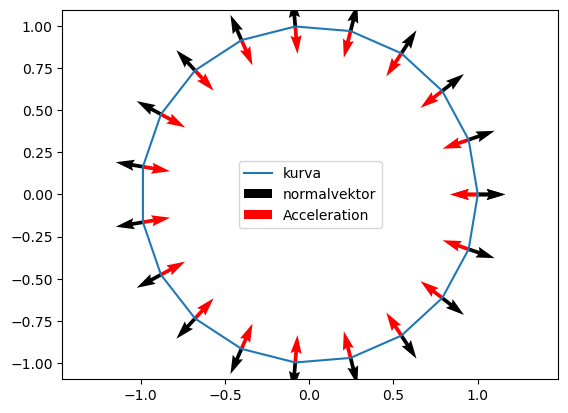

In [46]:
r = lambda t: (jnp.cos(t), jnp.sin(t)) # En cirkel


t = jnp.linspace(0, 2 * jnp.pi, 20) # 20 punkter på cirkeln
(rx, ry) = vmap(r)(t)               # Punkterna på cirkeln
(drx, dry) = vmap(jacrev(r))(t)     # Derivatan av cirkelns parametrisering
(ddrx, ddry) = vmap(jacfwd(jacrev(r)))(t) # Andra derivatan av cirkelns parametrisering

# Plotta
plt.plot(rx, ry, label="kurva")
plt.quiver(rx, ry, dry, -drx, label="normalvektor")
plt.quiver(rx, ry, ddrx, ddry, color="red", label="Acceleration")
plt.axis('equal')
plt.legend()


Nu frågar vi oss, hur kan vi lösa en PDE innanför en kurva? Till exempel, låt oss lösa Poissons ekvation:
$$
    \Delta u(x) = 0, \quad x \;\text{innanför}\quad r
$$
Med randvillkor
$$
    u(x) = g(x),\quad x\;\text{på}\quad r.
$$
Från inlämningsuppgiften jag skickade till er, kan man kanske komma ihåg att $u$ kan lösas som en randintegralekvation. Nämligen, $u$ kan uttryckas som en integral:
$$
    u(x) = \int_r \mu(y)\nabla\log(\|x-y\|)\cdot \hat n(y)\|\mathrm{d}y\|
$$
Där $n(y)$ är normalvektorn på randen $r$ och $\mu(y)$ är en <b>densitet</b> som man kan få fram genom att lösa ekvationssystemet:
$$
    \frac{1}{2}\mu(x) + \frac{1}{2\pi}\int_r \mu(y)\nabla\log(\|x-y\|)\cdot \hat n(y)\|\mathrm{d}y\| = g(x).
$$
Vi vill lösa detta ekvationssystem med jax! Om man skriver om uttrycket ovan med hjälp av parametriseringen $r(t)$ får man, om man definierar $\tilde \mu(t) = \mu(r(t))$, att
$$
    \frac{1}{2}\tilde\mu(t) + \frac{1}{2\pi}\int_0^{2\pi}\tilde\mu(s)\frac{\det([r(s)-r(t), r'(s)])}{\|r(s)-r(t)\|^2}\mathrm{d}s = \tilde g(t).
$$
Vi kan skriva uttrycket ovan mer kortfattat som
$$
    \mu = (\tfrac{1}{2}I + A_r)^{-1}g, \qquad u = B_r\mu,\qquad \text{eller}\qquad u = B_r(\tfrac{1}{2}I + A_r)^{-1}g
$$
Där $A_r$ och $B_r$ är integraloperatorer, som beror på $r$. Säg att vi nu vill minimera medelvärdet $\int_\ell u(x)\mathrm{d}x$ av $u$ över någon linje $\ell$. Då Kan man se det som att $u$ är en funktion av $r$:
$$
    r \mapsto \int_\ell u \quad \text{eftersom}\quad r\mapsto (A_r, B_r)\mapsto B_r(\tfrac{1}{2}I + A_r)^{-1}g = u\mapsto \int_\ell u.
$$
För att kunna derivera $\int_\ell u$ med avseende på $r$, vill vi implementera alla avbildningarna ovanför i ``jax``. Det svåraste kommer nog att vara inversen $(\dots)^{-1}$. Det intressanta är att vi kan nöja oss med att implementera bara <b>verkan</b> av operatorerna $A_r$ och $B_r$. Det vill säga, givet $r$ och en funktion $h$, så vill vi implementera $(r, h)\mapsto A_r h$ och $(r, h)\mapsto B_r h$ som funktioner i ``jax``.

In [47]:

def A(r, h):
    """Givet h och r, båda på randen, beräkna randintegralen 
    $$
        1/(2pi) * \integ{0->2pi} h(s) * det([r(s)-r(t), r'(s)]) / ||r(s)-r(t)||^2 ds
    $$
    Kräver att hantera fallet då s=t separat, eftersom det annars blir avrundningsfel pga division med 0.
    """
    pass

r_ab = lambda a,b: lambda t: (a * jnp.cos(t), b * jnp.sin(t)) # En cirkel

def sub(a, b):
    return (a[0]-b[0], a[1]-b[1])

def det(a, b):
    return a[0]*b[1] - a[1]*b[0]

def norm2(a):
    return a[0]**2 + a[1]**2

def kern_bdry(r, s, t, tol=1e-6):
    """Kärnan i integralen för att beräkna A(r, h).
    Då s -> t får vi ett gränsvärde: det()
    """
    close = abs(s-t) < tol
    kern_nolim_ = lambda s: kern_nolim(r, s, t)
    kern_lim_ = lambda s: kern_lim(r, s)
    return cond(close, kern_lim_, kern_nolim_, s)

def kern(r, s, x):
    delta_r = sub(r(s), x)
    return det(delta_r, jacrev(r)(s)) / norm2(delta_r)

def kern_nolim(r, s, t):
    return kern(r, s, r(t))

def kern_lim(r, s):
    dr = jacrev(r)(s)
    ddr = jacfwd(jacrev(r))(s)
    return det(ddr, dr) / norm2(dr) / 2

def integrate(f, t_discr, w_discr):
    # Diskretisera r och h, och integrera över randen med Trapetsregeln.
    # 200 punkter på cirkeln (sista punkten är samma som första)
    return jnp.sum(vmap(f)(t_discr) * w_discr)

def integral_operator(r, h, x, **kwargs):
    integrand = lambda t: h(t) * kern(r, t, x)
    return integrate(integrand, **kwargs) / (2 * jnp.pi)

def boundary_operator(r, h, t, **kwargs):
    integrand = lambda s: h(s) * kern_bdry(r, s, t)
    return integrate(integrand, **kwargs) / (2 * jnp.pi)

def matvec(r, v_discr, t_discr, w_discr):
    vw_discr = v_discr * w_discr
    matvec_t = lambda t: boundary_operator(r, lambda s: 1, t, t_discr=t_discr, w_discr=vw_discr)
    return vmap(matvec_t)(t_discr)

def trapezoid(N):
    # Ta inte med sista punkten, eftersom den är samma som första
    t = jnp.linspace(0, 2 * jnp.pi, N+1)[:-1] 
    w = jnp.ones(N) / float(N)
    return {"t_discr": t, "w_discr": w}

def plot_curve(r, **kwargs):
    t = jnp.linspace(0, 2 * jnp.pi, 200)
    rx, ry = vmap(r)(t)
    plt.plot(rx, ry, **kwargs)

def mask(tol, t_discr, w_discr):
    """Det visar sig att om man väljer densiteten mu(t)=1 så blir integralen k(s, x)m(s)ds
    över cirkeln precis 1 om x ligger inuti domänen, och precis -1 om x ligger utanför.
    Detta kan användas för att skapa en mask som talar om vilka punkter som ligger inuti domänen."""
    hw_discr = jnp.ones_like(t_discr) * w_discr
    mask = lambda x, y: \
        integral_operator(r, lambda t: 1, (x, y), t_discr=t_discr, w_discr=hw_discr) > tol
    return mask

-1.2249075e-08
-3.5515768e-09


Text(0.5, 0.98, 'Svår densitet nära hörn')

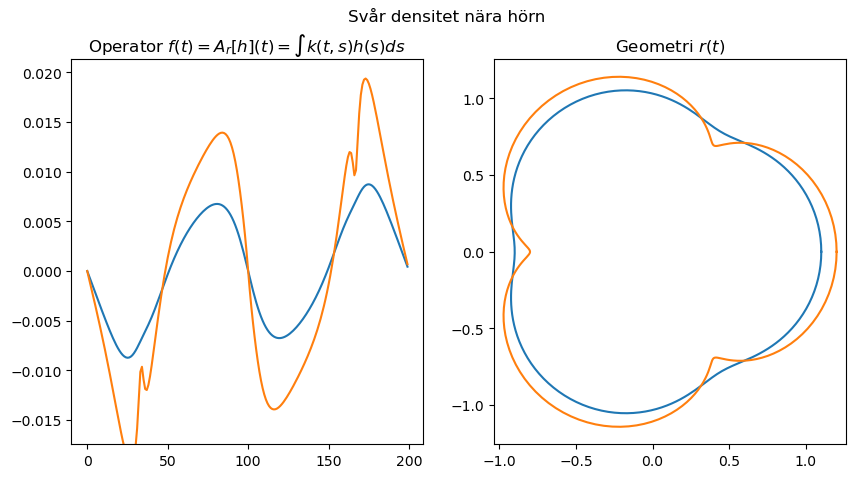

In [48]:
r_a = lambda a: lambda t: (jnp.cos(t) + a*jnp.cos(4*t), jnp.sin(t)+a*jnp.sin(4*t)) # En cirkel
g = lambda t: jnp.sin(t)

[t_discr, w_discr] = trapezoid(200).values()
g_discr = vmap(g)(t_discr)
f_discr_a = lambda a:  matvec(r_a(a), g_discr, t_discr, w_discr)
avg_f_a = lambda a: jnp.sum(f_discr_a(a) * w_discr)



plt.figure(figsize=(10,5))
for a in [.1,.2]:
    f_discr = f_discr_a(a)
    
    print(grad(avg_f_a)(a))
        
    plt.subplot(1,2,1)
    plt.plot(f_discr)
    plt.ylim([min(f_discr)*0.9, max(f_discr)*1.1])
    plt.title("Operator $f(t) = A_r[h](t) = \int k(t, s)h(s)ds$")

    plt.subplot(1,2,2)
    plot_curve(r_a(a))
    plt.axis("equal")
    plt.title("Geometri $r(t)$")
    
plt.suptitle("Svår densitet nära hörn")

Nu löser vi istället ut $\mu$ från $g$.

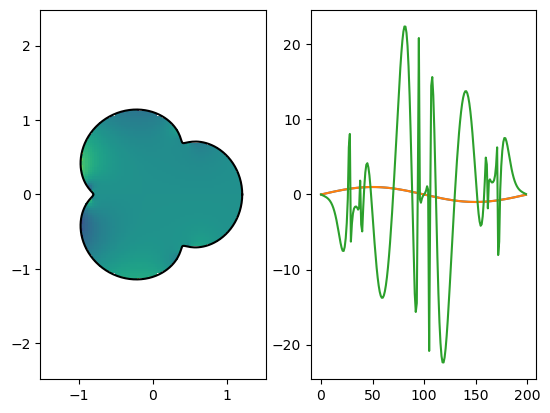

In [49]:
from jaxopt.linear_solve import solve_gmres as solve

def plot_field(mu_discr, t_discr, w_discr, r, mask, **kwargs):
    muw_discr = mu_discr * w_discr
    field = lambda x, y: integral_operator(r, lambda t: 1, (x, y), t_discr=t_discr, w_discr=muw_discr)
    masked_field = lambda x, y: jnp.where(mask(x, y), field(x, y), jnp.nan)
    
    x = jnp.linspace(-1.5, 1.5, 100)
    X, Y = jnp.meshgrid(x, x)
    Z = vmap(masked_field)(X.flatten(), Y.flatten()).reshape(X.shape)
    plt.pcolormesh(X, Y, Z, **kwargs)


r_a = lambda a: lambda t: (jnp.cos(t) + a*jnp.cos(4*t), jnp.sin(t)+a*jnp.sin(4*t)) # En cirkel
r = r_a(.2)

g = lambda t: jnp.sin(t)

[t_discr, w_discr] = trapezoid(200).values()
g_discr = vmap(g)(t_discr)

matvec_discr = lambda v_discr: v_discr/2 + matvec(r, v_discr, t_discr, w_discr)
mu_discr = solve(matvec_discr, g_discr, tol=1e-3, maxiter=1000)


plt.subplot(1,2,1)
plot_field(mu_discr, t_discr, w_discr, r, mask(0.1, t_discr, w_discr))#, vmin=0, vmax=1)# x**2 + y**2 < 0.99**2)
plot_curve(r, color="black")
plt.axis("equal")

plt.subplot(1,2,2)
#plt.plot(mu_discr)
def eval_close(t):
    eps = 0.01
    (rx, ry) = r(t)
    return integral_operator(r, lambda t: 1, ((1-eps)*rx, (1-eps)*ry), 
                             t_discr=t_discr, w_discr=w_discr*mu_discr)

plt.plot(g_discr)
plt.plot(matvec_discr(mu_discr))    
plt.plot(vmap(eval_close)(t_discr))